<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>


# Jupyter Notebook for Chapter 9

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import datetime
import pytz
import os
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa import stattools

import warnings
warnings.filterwarnings('ignore')

/Users/nehrend/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
tz = pytz.timezone('America/New_York')
os.chdir('/Users/nehrend/external/work/algo_trading_book/')
def millions(x, pos):
    return '%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context('paper')
sns.set_palette("muted")

## Order Size Normalization

In [9]:
amzn_d = pd.read_csv('datasets/AMZN.csv',parse_dates=True,index_col=0)
amzn_d.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-19,990.000000,991.049988,980.23999,986.609985,986.609985,3108200
2017-10-20,993.530029,994.619995,982.00000,982.909973,982.909973,2365100
2017-10-23,986.729980,986.780029,962.50000,966.299988,966.299988,3494100
2017-10-24,969.000000,979.849976,965.00000,975.900024,975.900024,2704800
2017-10-25,978.000000,984.440002,966.23999,972.909973,972.909973,2830486


The daily volume is a very complex process with multiple seasonal components and regular shocks some of which are predicable (Earning announcements, Option Expiration, etc.) and some are "random". Let's look a the volume of a sample stock, AMZN (Amazon Inc.) from 2010 to date and also a zoomed in version for 2016.

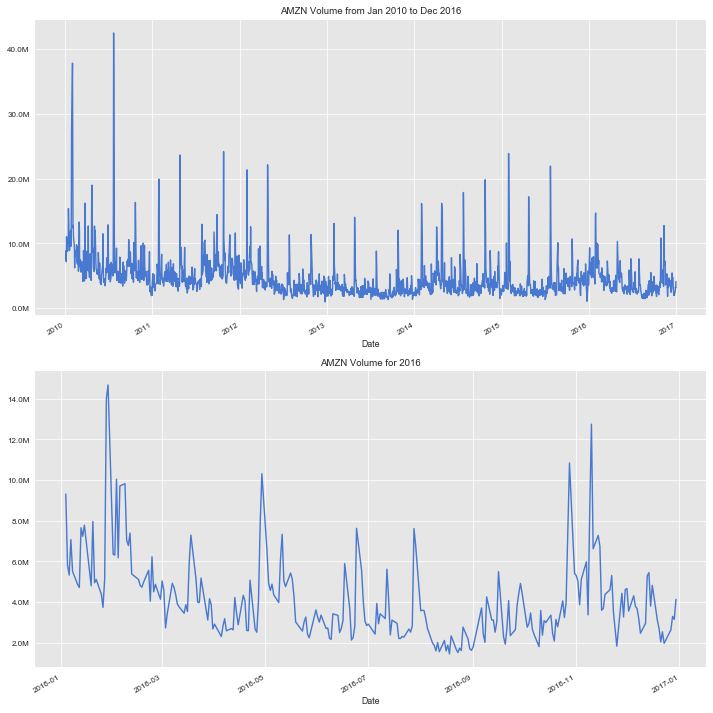

In [10]:
fig, ax = plt.subplots(2)
fig.set_size_inches(10.0, 10.0)
amzn_d.Volume['2010-01':'2016-12'].plot(ax=ax[0])
ax[0].set_title('AMZN Volume from Jan 2010 to Dec 2016')
ax[0].yaxis.set_major_formatter(formatter)
amzn_d.Volume['2016-01':'2016-12'].plot(ax=ax[1])
ax[1].set_title('AMZN Volume for 2016')
ax[1].yaxis.set_major_formatter(formatter)
sns.despine()

plt.tight_layout()
plt.savefig('./book/chapters/chapter_trade_data_models/figures/daily_volume.png', format='png', dpi=300)

Often in execution we look at order size normalized by some form of rolling average. A common rolling window is 64 days as it includes a rolling quarter and alway incorporates one quarterly earnings day where volume is usually a lot higher. We look at the difference between Mean and Median. One, as we can see is smoother and more stable while the other one is more reactive but more noisy.

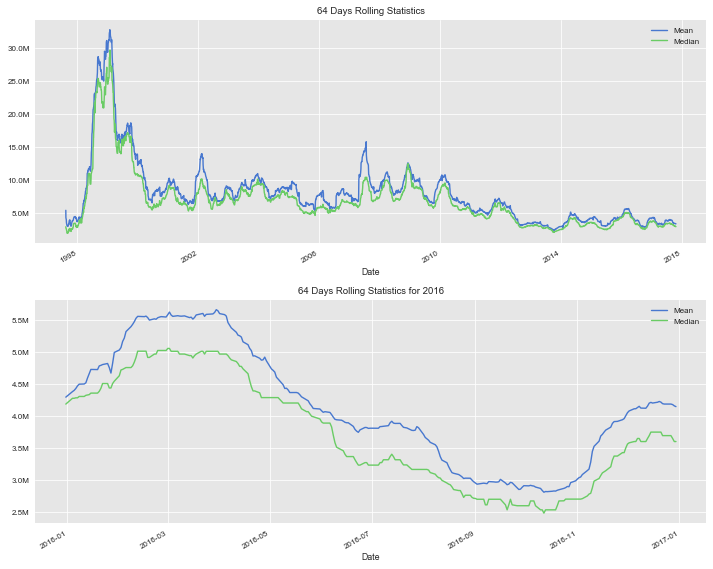

In [11]:
fig, ax = plt.subplots(2)
fig.set_size_inches(10.0, 8.0)
amzn_d.Volume.rolling(64).mean().dropna().plot(ax=ax[0])
amzn_d.Volume.rolling(64).median().dropna().plot(ax=ax[0])
ax[0].legend(labels=['Mean','Median'])
ax[0].set_title("64 Days Rolling Statistics")
ax[0].yaxis.set_major_formatter(formatter)
amzn_d.Volume['2015-10':'2016-12'].rolling(64).mean().dropna().plot(ax=ax[1])
amzn_d.Volume['2015-10':'2016-12'].rolling(64).median().dropna().plot(ax=ax[1])
ax[1].legend(labels=['Mean','Median'])
ax[1].set_title("64 Days Rolling Statistics for 2016")
ax[1].yaxis.set_major_formatter(formatter)
sns.despine()
plt.tight_layout()
plt.savefig('./book/chapters/chapter_trade_data_models/figures/adv.png', format='png', dpi=300)

Let's take a closer look at 2016 and see what we can do as far as a simple TS modeling using the tools we learned in Chapter 2

First let's look at stationarity by running the ADF Augmented Test. The p-value is very small consitent with the stationarity hypothesis



In [12]:
adf_result = stattools.adfuller(amzn_d.Volume['2016-01':'2016-12'], autolag='AIC')
print('p-Value: {:.3e} is less than 0.001. Series is stationary'.format(adf_result[1]))

p-Value: 9.858e-02 is less than 0.001. Series is stationary


Next let's look at the ACF and PACF to get an idea of AR and MA component but also some possible seasonal components. We see that the series could possibly be modeled as an ARMA(1,2) but there is likely some seasonal component at the roughly monthly level.

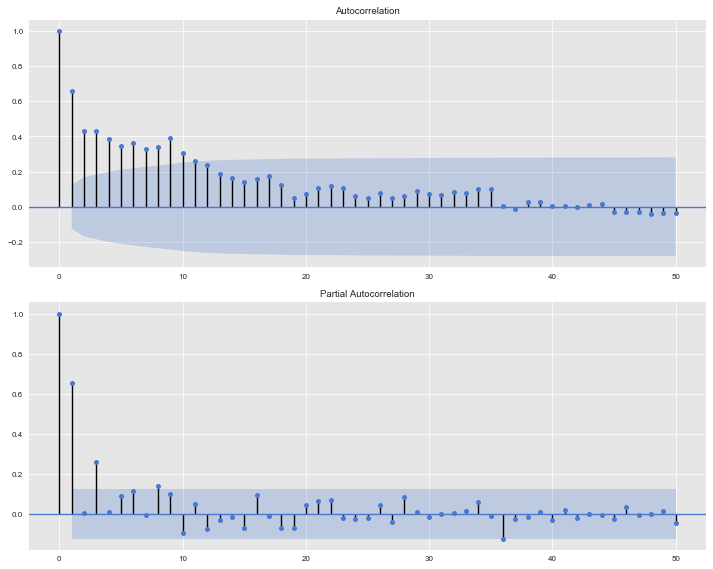

In [13]:
fig, ax = plt.subplots(2)
fig.set_size_inches(10.0, 8.0)
plot_acf(amzn_d.Volume['2016-01':'2016-12'], lags=50, ax=ax[0])
plot_pacf(amzn_d.Volume['2016-01':'2016-12'], lags=50, ax=ax[1])
plt.tight_layout()

Let's run a parameter scan to see which ARMA model is better suited. As it turns out ARMA(2,1) seems to do the best job.

In [14]:
# Optimize ARMA parameters
aicVal=[]
for ari in range(1, 3):
    for maj in range(1,3):
        arma_obj = stattools.ARMA(amzn_d.Volume['2016-01':'2016-11'].tolist(), order=(ari, maj)).fit(maxlag=30, method='mle', trend='nc')
        aicVal.append([ari, maj, arma_obj.aic])
pd.DataFrame(aicVal,columns=['AR(p)','MA(q)','AIC'])

,AR(p),MA(q),AIC
0,1,1,7282.482563
1,1,2,7249.052074
2,2,1,7259.182054
3,2,2,7251.044107
